In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)

import sklearn


TensorFlow 2.x selected.
<module 'tensorflow_core._api.v2.version' from '/tensorflow-2.1.0/python3.6/tensorflow_core/_api/v2/version/__init__.py'>


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output #just to clear the output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

# Core Learning Algorithms
*   Linear Regression
*   Classification
*   Clustering
*   Hidden Markov Models


## Linear Regression

# ***y = mx + c*** 

In [0]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval   = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

y_train = dftrain.pop('survived')
y_eval  = dfeval.pop('survived') # .pop removes the data from the original dataframe

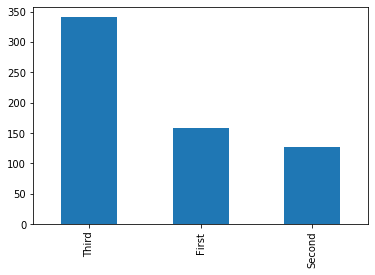

In [4]:
# dftrain.age.hist(bins=20) # frequency of age
# dftrain.sex.value_counts().plot(kind='barh')
dftrain['class'].value_counts().plot(kind ='bar')

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses','parch','class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [0]:
# BATCH SIZE -> data is loaded in small batch sizes, instead of loaded one by one.
# EPOCH -> number of times the model is going to see the same data (different order). Start with low epochs, it is possible that the model memorizes the training set then
                               ## performs low on testing set.
# INPUT SIZE -> The TensorFlow model requires that the data we pass comes in as a tf.data.Dataset object. Create a input function that can convert 
                # our current pandas dataframe into that object. 

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates tf.data.Dataset object with data and its labels.
    if shuffle:
      ds = ds.shuffle(1000) # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32  and repeat process for numer of epochs
    return ds # return a batch of the dataset
  return input_function # return a fucntion object for use

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn  = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Model
*   Creating
*   Training
*   Testing




In [7]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn) # train
result = linear_est.evaluate(eval_input_fn) # get model metrics/stats by testing on testing data

clear_output() # clears console output
print(result['accuracy'])


0.75


### Predictions


In [8]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[4])
print(y_eval.loc[4])
print(result[4]['probabilities'][1])



INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1tf6tvpf/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                          male
age                            34
n_siblings_spouses              0
parch                           0
fare                           13
class                      Second
deck                            D
emb

## Classification

In [9]:
train_path = tf.keras.utils.get_file('iris_training.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv')
test_path = tf.keras.utils.get_file('iris_test.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv')

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header = 0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header =0)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
train_y = train.pop("Species")
test_y = test.pop("Species")


def input_fn(features, labels, training=True, batch_size=256):
  # Convert the inputs to a Dataset
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

  # Shuffle and repeat if you are in training mode
  if training:
    dataset = dataset.shuffle(1000).repeat()

  return dataset.batch(batch_size)

# Feature columns describe how to use the input.
feature_columns = []
for key in train.keys():
  feature_columns.append(tf.feature_column.numeric_column(key=key))

### Model
*   DNNClassifier (Deep Neural Network)
*   LinearClassifier




In [11]:
# Build a DNN with 2 hidden layers with 30 and 10 hiiden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively
    hidden_units = [30,10],
    # The model must choose between 3 classes.
    n_classes =3)

## Train the classifier.
classifier.train(
    input_fn=lambda: input_fn(train,train_y, training=True),
    steps=5000)

## Evaluate the model
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test,test_y, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl97gf_u5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

### Predict


In [12]:
def input_fn(features, batch_size=256):
  # Convert the inputs to a Dataset without labels
  return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict  = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid:
    val = input(feature+": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]


predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
  class_id = pred_dict['class_ids'][0]
  proabability = pred_dict['probabilities'][class_id]

  print('Prediction is "{}" ({:.1f}%)'.format(
      SPECIES[class_id], 100 * proabability))

Please type numeric values as prompted.
SepalLength: 2.4
SepalWidth: 2.6
PetalLength: 6.5
PetalWidth: 6.3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl97gf_u5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Virginica" (88.6%)


## Clustering

### Basic Algorithm of K-Means
*   Step 1: Randomly pick K points to place K centroids
*   Step 2: Assign all of the data points to the centroids by distance. The closest centroid to a point is the one it is assigned to.
*   Step 3: Average all of the points belonging to each centroid to find the middle of those clusters. Place the corresponding centroids into that position.
*   Step 4: Reassign every point once again to the closest centroid.
*   Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.





## Hidden Markov Models
The Hidden Markov Model is a finite set of stats, each of which is associated with a (generally multidimensional) probability distribution. Transitions among the states are governed by a set of probabilities call transition probabilities.
A hidden markov model works with probabilites to predict future events or states.

In [0]:
import tensorflow_probability as tfp

In [0]:
tfd = tfp.distributions # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.8,0.2]) 
transition_distribution = tfd.Categorical(probs = [[0.7, 0.3],
                                                    [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.]) # the loc argument represents the mean and the scale is the standard deviation.


model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution = observation_distribution,
    num_steps = 7
)

In [18]:
mean = model.mean()
# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:
  print(mean.numpy())

[3.       6.       7.5      8.249999 8.625001 8.812501 8.90625 ]
